### Loads/inspects in the Simonson adata and makes it compatible for combining with other datasets

#### Simonson et al. 2023 (Ellinor Lab)

1. Technology: 10x 3' v3
2. Cell vs. nuclei: Nuclei only
3. Region: LV

Profiled transcriptome of ~100,000 human cardiac nuclei from non-infarct region of LV of 7 ICM transplant recipients and 8 NF controls

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
from collections import Counter
import re
import gc
import scanpy.external as sce

In [2]:
def preprocess_adata(adata, donor_key, leiden_resolution):
    '''
    Performs: 
    1. library size normalization and log scaling
    2. identification of top 2K highly variable genes, 
    3. Principal component analysis
    4. Harmony integration
    5. Neighbor neighbors computation in Harmony integration embedding
    6. Leiden clustering 
    
    Parameters:
    adata (AnnData): adata object before preprocessing
    donor_key: the column in adata.obs that corresponds to the donor information (should be 'donor_id')
    leiden_resolution: resolution for leiden clustering, higher means more clusters will be detected

    Returns:
    adata: Postprocessed adata
    '''
    # Normalizing to median total counts
    sc.pp.normalize_total(adata)
    # Logarithmize the data
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key=donor_key)
    sc.tl.pca(adata)
    sce.pp.harmony_integrate(adata, donor_key)
    sc.pp.neighbors(adata, use_rep = "X_pca_harmony")
    sc.tl.umap(adata)
    sc.pl.umap(adata, color=donor_key, size=2)
    sc.tl.leiden(adata, flavor="igraph", n_iterations=2, resolution = 0.5)
    return(adata)

Load in the Simonson dataset

In [3]:
# read in the entire dataset
adata = sc.read_h5ad("ICM_scportal_05.24.2022.h5ad")
# filter to only the non-diseased donors
adata = adata[adata.obs.disease == "NF", :]
adata

View of AnnData object with n_obs × n_vars = 60345 × 36601
    obs: 'biosample_id', 'donor_id', 'disease', 'sex', 'age', 'cell_type_leiden0.5', 'sub_cluster', 'cellbender_ncount', 'cellbender_ngenes', 'cellranger_percent_mito', 'exon_prop', 'cellbender_entropy', 'cellranger_doublet_scores'
    var: 'gene_ids', 'feature_types', 'genome'
    obsm: 'X_umap'
    layers: 'cellranger_raw'

In [4]:
# check that these are the raw counts
adata.X.sum(axis = 1)

matrix([[9883.],
        [9817.],
        [9877.],
        ...,
        [ 231.],
        [ 263.],
        [ 290.]], dtype=float32)

In [5]:
# extract the relevant metadata
metadata = adata.obs[['cell_type_leiden0.5', 'sex', 'age', 'donor_id']]

# for later consistency, change the column names
metadata = metadata.rename(columns={'cell_type_leiden0.5': 'cell_type'})

# add additional metadata
metadata['technology'] = '3prime-v3'
metadata['cell_or_nuclei'] = 'Nuclei'
metadata['study'] = 'Simonson 2023'
metadata['region'] = 'LV'

# add back metadata to data
adata.obs = metadata
adata.obs.head()

,cell_type,sex,age,donor_id,technology,cell_or_nuclei,study,region
ACCAACAAGGGTTTCT-1-1,Cardiomyocyte I,female,47,P1452,3prime-v3,Nuclei,Simonson 2023,LV
ATTCACTTCCCGAGGT-1-1,Cardiomyocyte I,female,47,P1452,3prime-v3,Nuclei,Simonson 2023,LV
ATGCATGCACGCTTAA-1-1,Cardiomyocyte I,female,47,P1452,3prime-v3,Nuclei,Simonson 2023,LV
CAACCTCTCAGACCCG-1-1,Cardiomyocyte I,female,47,P1452,3prime-v3,Nuclei,Simonson 2023,LV
CTCCCAAGTTCGTAAC-1-1,Cardiomyocyte I,female,47,P1452,3prime-v3,Nuclei,Simonson 2023,LV


In [6]:
# check that the var names are gene symbols, not ENSEMBL ID
adata.var_names

Index(['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3',
       'AL627309.2', 'AL627309.5', 'AL627309.4', 'AP006222.2', 'AL732372.1',
       ...
       'AC133551.1', 'AC136612.1', 'AC136616.1', 'AC136616.3', 'AC136616.2',
       'AC141272.1', 'AC023491.2', 'AC007325.1', 'AC007325.4', 'AC007325.2'],
      dtype='object', length=36601)

In [7]:
# store the raw counts
adata.layers["counts"] = adata.X

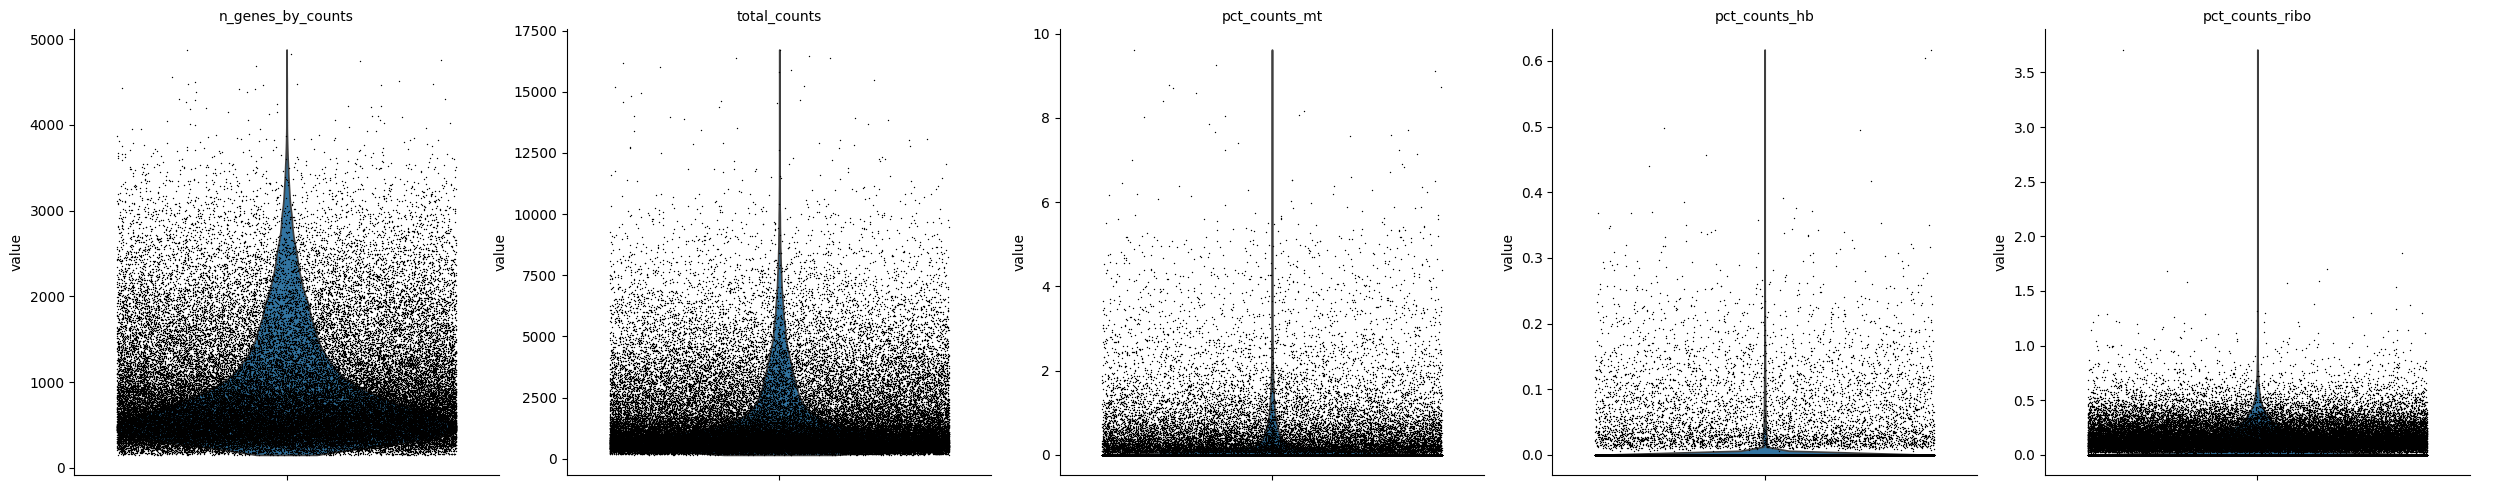

Filtered out 124 cells
CPU times: user 25.6 s, sys: 35.2 s, total: 1min
Wall time: 10.4 s


In [8]:
%%time 

adata.var["mt"] = adata.var_names.str.startswith("MT-")
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True)
sc.pl.violin(adata, ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_hb", "pct_counts_ribo"], 
             jitter=0.4,multi_panel=True,)

# filter the cells out that are above the specified thresholds for mitochondrial, ribosomal, and hemoglobin reads
mito_threshold = 5.0
ribo_threshold = 5.0
hb_threshold = 5.0 

adata_size_before = adata.shape[0]

adata = ( adata[(adata.obs.pct_counts_mt <= mito_threshold) &
                (adata.obs.pct_counts_ribo <= ribo_threshold) &
                (adata.obs.pct_counts_hb <= hb_threshold), :].copy()
        )

adata_size_after = adata.shape[0]
num_filtered = adata_size_before - adata_size_after
print(f"Filtered out {num_filtered} cells")

In [9]:
%%time
donor_key = "donor_id"
# predict the doublets with scrublet
sc.pp.scrublet(adata, batch_key = donor_key)
num_doublets = adata[adata.obs.predicted_doublet == True].shape[0]
# filter out the doublets
adata = adata[adata.obs.predicted_doublet == False, :].copy()
print(f"Filtered out {num_doublets} likely doublets")

Filtered out 305 likely doublets
CPU times: user 27min 19s, sys: 35min 41s, total: 1h 3min
Wall time: 8min 48s


2024-10-04 21:33:55,869 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-10-04 21:34:00,614 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-10-04 21:34:00,922 - harmonypy - INFO - Iteration 1 of 10
2024-10-04 21:34:22,173 - harmonypy - INFO - Iteration 2 of 10
2024-10-04 21:34:46,195 - harmonypy - INFO - Iteration 3 of 10
2024-10-04 21:35:07,808 - harmonypy - INFO - Iteration 4 of 10
2024-10-04 21:35:38,352 - harmonypy - INFO - Iteration 5 of 10
2024-10-04 21:36:01,413 - harmonypy - INFO - Iteration 6 of 10
2024-10-04 21:36:22,055 - harmonypy - INFO - Iteration 7 of 10
2024-10-04 21:36:41,548 - harmonypy - INFO - Converged after 7 iterations


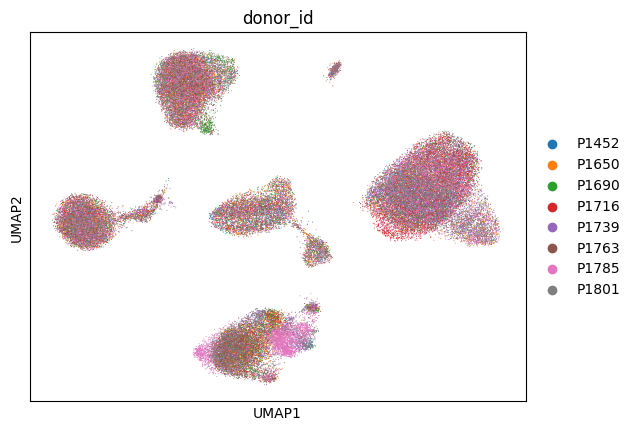

In [10]:
LEIDEN_RES = 0.5
adata = preprocess_adata(adata = adata, 
                         donor_key = "donor_id",
                         leiden_resolution = LEIDEN_RES)

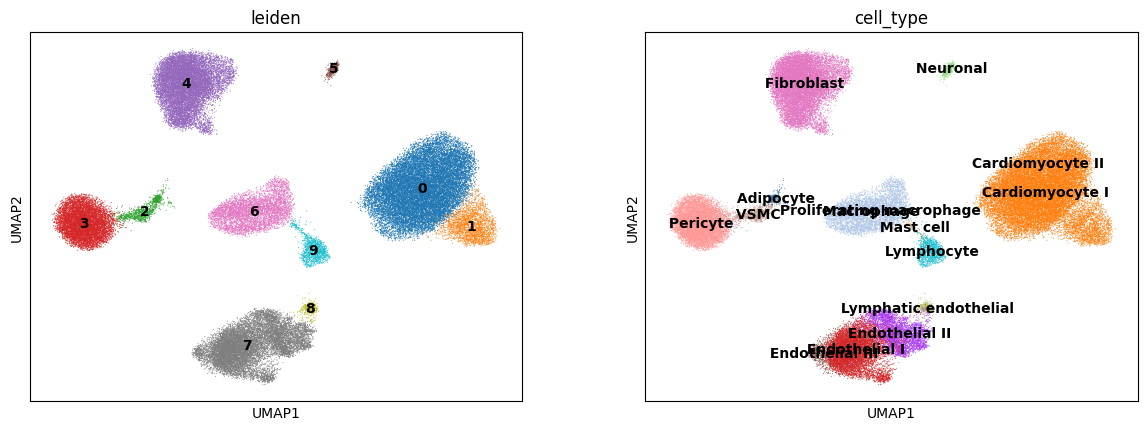

In [11]:
sc.pl.umap(adata, color=["leiden", "cell_type"], size=2, legend_loc = "on data")

In [12]:
set(adata.obs.cell_type)

{' Adipocyte',
 ' Cardiomyocyte I',
 ' Cardiomyocyte II',
 ' Endothelial I',
 ' Endothelial II',
 ' Endothelial III',
 ' Fibroblast',
 ' Lymphatic endothelial',
 ' Lymphocyte',
 ' Macrophage',
 ' Mast cell',
 ' Neuronal',
 ' Pericyte',
 ' Proliferating macrophage',
 ' VSMC'}

In [13]:
adata.obs["consistent_cell_type"] = adata.obs["cell_type"].map(
    {
        " Adipocyte": "Adipocyte",
        " Cardiomyocyte I": "Cardiomyocyte",
        " Cardiomyocyte II": "Cardiomyocyte",
        " Endothelial I": "Endothelial",
        " Endothelial II": "Endothelial",
        " Endothelial III": "Endothelial",
        " Fibroblast": "Fibroblast",
        " Lymphocyte": "Lymphoid",
        " Macrophage": "Myeloid",
        " Mast cell": "Mast",
        " Lymphatic endothelial": "LEC",
        " Neuronal": "Neuronal",
        " Pericyte": "Pericyte",
        " Proliferating macrophage": "Myeloid",
        " VSMC": "vSMC",
    }
)

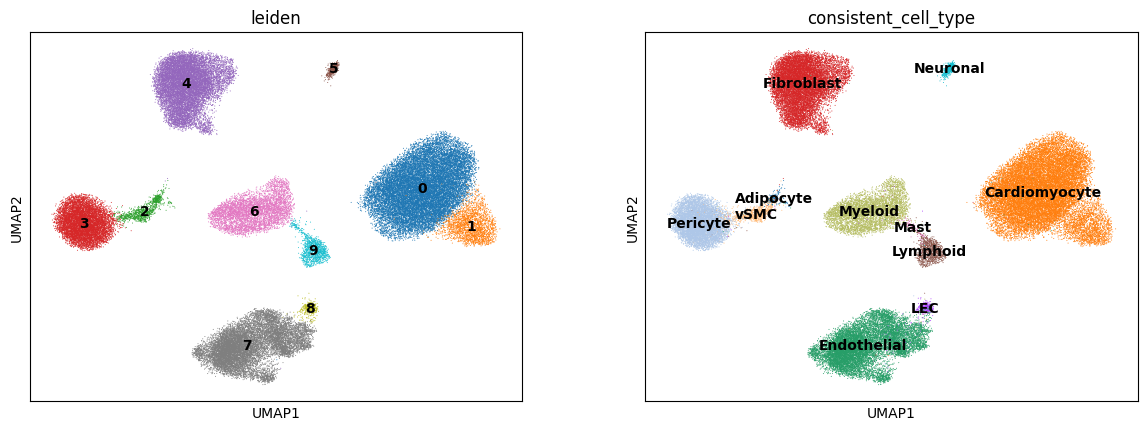

In [14]:
sc.pl.umap(adata, color=["leiden", "consistent_cell_type"], size=2, legend_loc = "on data")

In [15]:
Counter(adata.obs.consistent_cell_type)

Counter({'Cardiomyocyte': 20754,
         'Endothelial': 12192,
         'Fibroblast': 11710,
         'Pericyte': 7307,
         'Myeloid': 4898,
         'Lymphoid': 1061,
         'vSMC': 839,
         'Neuronal': 446,
         'LEC': 400,
         'Adipocyte': 206,
         'Mast': 103})

In [16]:
adata.write("processed_Simonson_ND.h5ad")